In [1]:
# shared across tasks
from plb.optimizer.optim import Adam
from plb.engine.taichi_env import TaichiEnv
from plb.config.default_config import get_cfg_defaults, CN

import os
import cv2
import numpy as np
import taichi as ti
ti.init(arch=ti.gpu)
import matplotlib.pyplot as plt
from plb.config import load
from tqdm.notebook import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] mode=release
[Taichi] preparing sandbox at /tmp/taichi-72boifd2
[Taichi] version 0.7.20, llvm 10.0.0, commit 284f75ed, linux, python 3.8.11
[I 06/25/22 12:31:54.854] [shell.py:_shell_pop_print@35] Graphical python shell detected, using wrapped sys.stdout
[Taichi] Starting on arch=cuda
[Taichi] Starting on arch=cuda


ENV:
  loss:
    soft_contact: False
    target_path: envs/assets/Chopsticks3D-v1.npy
    weight:
      contact: 1
      density: 10
      sdf: 10
  n_observed_particles: 200
PRIMITIVES: [{'shape': 'Capsule', 'h': 0.2, 'r': 0.045, 'init_pos': '(0.35, 0.4, 0.5)', 'init_rot': '(1., 0., 0., 0.)', 'color': '(0.8, 0.8, 0.8)', 'friction': 1.0, 'action': {'dim': 6, 'scale': '(0.02, 0.02, 0.02, 0.04, 0.04, 0.04)'}}, {'shape': 'Capsule', 'h': 0.2, 'r': 0.045, 'init_pos': '(0.65, 0.4, 0.5)', 'init_rot': '(1., 0., 0., 0.)', 'color': '(0.8, 0.8, 0.8)', 'friction': 1.0, 'action': {'dim': 6, 'scale': '(0.02, 0.02, 0.02, 0.04, 0.04, 0.04)'}}, {'shape': 'Capsule', 'h': 0.13, 'r': 0.025, 'init_pos': '(0.5, 0.1, 0.5)', 'init_rot': '(1., 0., 0., 0.)', 'color': '(0.2, 0.2, 0.2)', 'friction': 15.0}]
RENDERER:
  bake_size: 6
  camera_pos: (0.5, 1.2, 4.0)
  camera_pos_1: (0.5, 2.5, 2.2)
  camera_pos_2: (0.5, 2.5, 2.2)
  camera_pos_3: (0.5, 2.5, 2.2)
  camera_pos_4: (0.5, 2.5, 2.2)
  camera_rot: (0.2, 0)
  ca

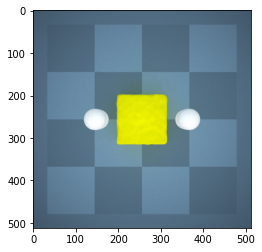

In [2]:
task_name = 'ngrip'
env_type = '_fixed'

# gripper_fixed.yml
cfg = load(f"../envs/gripper{env_type}.yml") 
print(cfg)
env = TaichiEnv(cfg, nn=False, loss=False)
env.initialize()
state = env.get_state()

env.set_state(**state)
taichi_env = env
print(env.renderer.camera_pos)
env.renderer.camera_pos[0] = 0.5
env.renderer.camera_pos[1] = 2.5
env.renderer.camera_pos[2] = 0.5
env.renderer.camera_rot = (1.57, 0.0)

env.primitives.primitives[0].set_state(0, [0.3, 0.4, 0.5, 1, 0, 0, 0])
env.primitives.primitives[1].set_state(0, [0.7, 0.4, 0.5, 1, 0, 0, 0])

env.render('plt')

action_dim = taichi_env.primitives.action_dim

In [3]:
cwd = os.getcwd()
root_dir = cwd + "/../.."
print(f'root: {root_dir}')

task_params = {
    "mid_point": np.array([0.5, 0.14, 0.5, 0, 0, 0]),
    "sample_radius": 0.4,
    "len_per_grip": 30,
    "len_per_grip_back": 10,
    "floor_pos": np.array([0.5, 0, 0.5]),
    "n_shapes": 3, 
    "n_shapes_floor": 9,
    "n_shapes_per_gripper": 11,
    "gripper_mid_pt": int((11 - 1) / 2),
    "gripper_rate_limits": np.array([0.14, 0.06]), # ((0.4 * 2 - (0.23)) / (2 * 30), (0.4 * 2 - 0.15) / (2 * 30)),
    "p_noise_scale": 0.01,
}

if env_type == '':
    task_params["p_noise_scale"] = 0.03

print(f'p_noise_scale: {task_params["p_noise_scale"]}')

root: /home/haochen/projects/RoboCraft/simulator/plb/algorithms/../..
p_noise_scale: 0.01


In [4]:
def set_parameters(env: TaichiEnv, yield_stress, E, nu):
    env.simulator.yield_stress.fill(yield_stress)
    _mu, _lam = E / (2 * (1 + nu)), E * nu / ((1 + nu) * (1 - 2 * nu))  # Lame parameters
    env.simulator.mu.fill(_mu)
    env.simulator.lam.fill(_lam)


def update_camera(env):
    env.renderer.camera_pos[0] = 0.5
    env.renderer.camera_pos[1] = 2.5
    env.renderer.camera_pos[2] = 0.5
    env.renderer.camera_rot = (1.57, 0.0)
    env.render_cfg.defrost()
    env.render_cfg.camera_pos_1 = (0.5, 2.5, 2.2)
    env.render_cfg.camera_rot_1 = (0.8, 0.)
    env.render_cfg.camera_pos_2 = (2.4, 2.5, 0.2)
    env.render_cfg.camera_rot_2 = (0.8, 1.8)
    env.render_cfg.camera_pos_3 = (-1.9, 2.5, 0.2)
    env.render_cfg.camera_rot_3 = (0.8, -1.8)
    env.render_cfg.camera_pos_4 = (0.5, 2.5, -1.8)
    env.render_cfg.camera_rot_4 = (0.8, 3.14)


def update_primitive(env, prim1_list, prim2_list):
    env.primitives.primitives[0].set_state(0, prim1_list)
    env.primitives.primitives[1].set_state(0, prim2_list)


def save_files(env, rollout_dir, i):
    files = glob.glob(f"{root_dir}/dataset/{task_name}/{i:03d}/*")
    for f in files:
        os.remove(f)
        
    os.makedirs(f"{rollout_dir}/{i:03d}", exist_ok=True)
    with open(f"{rollout_dir}/{i:03d}"+"/cam_params.npy", 'wb') as f:
        ext1=env.renderer.get_ext(env.render_cfg.camera_rot_1, np.array(env.render_cfg.camera_pos_1))
        ext2=env.renderer.get_ext(env.render_cfg.camera_rot_2, np.array(env.render_cfg.camera_pos_2))
        ext3=env.renderer.get_ext(env.render_cfg.camera_rot_3, np.array(env.render_cfg.camera_pos_3))
        ext4=env.renderer.get_ext(env.render_cfg.camera_rot_4, np.array(env.render_cfg.camera_pos_4))
        intrinsic = env.renderer.get_int()
        cam_params = {'cam1_ext': ext1, 'cam2_ext': ext2, 'cam3_ext': ext3, 'cam4_ext': ext4, 'intrinsic': intrinsic}
        np.save(f, cam_params)


from transforms3d.quaternions import mat2quat
from transforms3d.axangles import axangle2mat
def random_rotate(mid_point, gripper1_pos, gripper2_pos, z_vec):
    mid_point = mid_point[:3]
    z_angle = np.random.uniform(0, np.pi)
    z_mat = axangle2mat(z_vec, z_angle, is_normalized=True)
    all_mat = z_mat
    quat = mat2quat(all_mat)
    return gripper1_pos, gripper2_pos, quat


def random_pose(task_name):
    p_noise_x = task_params["p_noise_scale"] * (np.random.randn() * 2 - 1)
    p_noise_z = task_params["p_noise_scale"] * (np.random.randn() * 2 - 1)
    if task_name == 'ngrip' or task_name == 'ngrip_3d':
        p_noise = np.clip(np.array([p_noise_x, 0, p_noise_z]), a_min=-0.1, a_max=0.1)
    else:
        raise NotImplementedError
    
    new_mid_point = task_params["mid_point"][:3] + p_noise

    rot_noise = np.random.uniform(0, np.pi)

    x1 = new_mid_point[0] - task_params["sample_radius"] * np.cos(rot_noise)
    z1 = new_mid_point[2] + task_params["sample_radius"] * np.sin(rot_noise)
    x2 = new_mid_point[0] + task_params["sample_radius"] * np.cos(rot_noise)
    z2 = new_mid_point[2] - task_params["sample_radius"] * np.sin(rot_noise)
    y = new_mid_point[1]
    z_vec = np.array([np.cos(rot_noise), 0, np.sin(rot_noise)])
    if task_name == 'ngrip':
        gripper1_pos = np.array([x1, y, z1])
        gripper2_pos = np.array([x2, y, z2])
        quat = np.array([1, 0, 0, 0])
    elif task_name == 'ngrip_3d':
        gripper1_pos, gripper2_pos, quat = random_rotate(new_mid_point, np.array([x1, y, z1]), np.array([x2, y, z2]), z_vec)
    else:
        raise NotImplementedError
    return np.concatenate([gripper1_pos, quat]), np.concatenate([gripper2_pos, quat]), rot_noise


def get_obs(env, n_particles, t=0):
    x = env.simulator.get_x(t)
    v = env.simulator.get_v(t)
    step_size = len(x) // n_particles
    return x[::step_size], v[::step_size]


def select_tool(env, width):
    env.primitives.primitives[0].r[None] = width
    env.primitives.primitives[1].r[None] = width


In [5]:
import glob
from datetime import datetime
from tqdm.notebook import tqdm

i = 0
n_vid = 5
suffix = ''
n_grips = 3
zero_pad = np.array([0,0,0])

time_now = datetime.now().strftime("%d-%b-%Y-%H:%M:%S.%f")
rollout_dir = f"{root_dir}/dataset/{task_name}{env_type}{suffix}_{time_now}"

while i < n_vid: 
    print(f"+++++++++++++++++++{i}+++++++++++++++++++++")
    env.set_state(**state)
    taichi_env = env    
    update_camera(env)
    set_parameters(env, yield_stress=200, E=5e3, nu=0.2) # 200， 5e3, 0.2 # 300, 800, 0.2
    update_primitive(env, [0.3, 0.4, 0.5, 1, 0, 0, 0], [0.7, 0.4, 0.5, 1, 0, 0, 0])
    save_files(env, rollout_dir, i)
    action_dim = env.primitives.action_dim
    imgs = [] 
    true_idx = 0
    for k in range(n_grips):
        print(k)
        prim1, prim2, cur_angle = random_pose(task_name)
        update_primitive(env, prim1, prim2)
        if 'small' in suffix:
            tool_size = 0.025
        else:
            tool_size = 0.045
        select_tool(env, tool_size)
        
        gripper_rate_limit = [(task_params['sample_radius'] * 2 - (task_params['gripper_rate_limits'][0] + 2 * tool_size)) / (2 * task_params['len_per_grip']),
                              (task_params['sample_radius'] * 2 - (task_params['gripper_rate_limits'][1] + 2 * tool_size)) / (2 * task_params['len_per_grip'])]
        rate = np.random.uniform(*gripper_rate_limit)
        actions = []
        counter = 0 
        mid_point = (prim1[:3] + prim2[:3]) / 2
        prim1_direction = mid_point - prim1[:3]
        prim1_direction = prim1_direction / np.linalg.norm(prim1_direction)
        while counter < task_params["len_per_grip"]:
            prim1_action = rate * prim1_direction
            actions.append(np.concatenate([prim1_action/0.02, zero_pad, -prim1_action/0.02, zero_pad]))
            counter += 1
        counter = 0
        while counter < task_params["len_per_grip_back"]:
            prim1_action = -rate * prim1_direction
            actions.append(np.concatenate([prim1_action/0.02, zero_pad, -prim1_action/0.02, zero_pad]))
            counter += 1

        actions = np.stack(actions)
            
        for idx, act in enumerate(tqdm(actions, total=actions.shape[0])):
            env.step(act)
            obs = get_obs(env, 300)
            x = obs[0][:300]
            
            primitive_state = [env.primitives.primitives[0].get_state(0), env.primitives.primitives[1].get_state(0)]

            img = env.render_multi(mode='rgb_array', spp=3)
            rgb, depth = img[0], img[1]

            os.system('mkdir -p ' + f"{rollout_dir}/{i:03d}")
            
            for num_cam in range(4):
                cv2.imwrite(f"{rollout_dir}/{i:03d}/{true_idx:03d}_rgb_{num_cam}.png", rgb[num_cam][..., ::-1])
            with open(f"{rollout_dir}/{i:03d}/{true_idx:03d}_depth_prim.npy", 'wb') as f:
                np.save(f, depth + primitive_state + [tool_size])
            with open(f"{rollout_dir}/{i:03d}/{true_idx:03d}_gtp.npy", 'wb') as f:
                np.save(f, x)
            true_idx += 1

        print(true_idx)
    
    os.system(f'ffmpeg -y -i {rollout_dir}/{i:03d}/%03d_rgb_0.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {rollout_dir}/{i:03d}/vid{i:03d}.mp4')
    i += 1

+++++++++++++++++++0+++++++++++++++++++++
0


  0%|          | 0/40 [00:00<?, ?it/s]

[W 06/25/22 12:32:19.218] [type_check.cpp:visit@100] [$53420] Local store may lose precision (target = f32, value = f64) at
[W 06/25/22 12:32:19.218] [type_check.cpp:visit@101] 

[W 06/25/22 12:32:19.218] [type_check.cpp:visit@100] [$53422] Local store may lose precision (target = f32, value = f64) at
[W 06/25/22 12:32:19.218] [type_check.cpp:visit@101] 

[W 06/25/22 12:32:19.218] [type_check.cpp:visit@100] [$53424] Local store may lose precision (target = f32, value = f64) at
[W 06/25/22 12:32:19.218] [type_check.cpp:visit@101] 

[W 06/25/22 12:32:19.218] [type_check.cpp:visit@100] [$53426] Local store may lose precision (target = f32, value = f64) at
[W 06/25/22 12:32:19.218] [type_check.cpp:visit@101] 

[W 06/25/22 12:32:19.218] [type_check.cpp:visit@100] [$53428] Local store may lose precision (target = f32, value = f64) at
[W 06/25/22 12:32:19.218] [type_check.cpp:visit@101] 

[W 06/25/22 12:32:19.218] [type_check.cpp:visit@100] [$53430] Local store may lose precision (target = f3

/home/haochen/.local/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


40
1


  0%|          | 0/40 [00:00<?, ?it/s]

80
2


  0%|          | 0/40 [00:00<?, ?it/s]

120


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/haochen/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpr

+++++++++++++++++++1+++++++++++++++++++++
0


frame=  120 fps=0.0 q=-1.0 Lsize=    3194kB time=00:00:04.68 bitrate=5590.3kbits/s speed=8.19x    
video:3192kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.045244%
[libx264 @ 0x55bc2ae588c0] frame I:1     Avg QP:27.25  size: 31608
[libx264 @ 0x55bc2ae588c0] frame P:108   Avg QP:27.46  size: 27339
[libx264 @ 0x55bc2ae588c0] frame B:11    Avg QP:27.64  size: 25816
[libx264 @ 0x55bc2ae588c0] consecutive B-frames: 87.5%  0.0%  2.5% 10.0%
[libx264 @ 0x55bc2ae588c0] mb I  I16..4:  6.1% 90.9%  3.0%
[libx264 @ 0x55bc2ae588c0] mb P  I16..4:  0.3% 55.0%  2.5%  P16..4: 13.5% 17.8% 10.7%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x55bc2ae588c0] mb B  I16..4:  0.2% 42.9%  1.4%  B16..8: 33.8%  7.0%  5.7%  direct: 7.2%  skip: 1.8%  L0:49.4% L1:45.4% BI: 5.2%
[libx264 @ 0x55bc2ae588c0] 8x8 transform intra:95.2% inter:49.7%
[libx264 @ 0x55bc2ae588c0] coded y,uvDC,uvAC intra: 98.2% 22.1% 7.2% inter: 72.6% 5.2% 2.9%
[libx264 @ 0x55bc2ae588c0] i16 v,h,dc,p:  5% 17% 54% 25%
[l

  0%|          | 0/40 [00:00<?, ?it/s]

40
1


  0%|          | 0/40 [00:00<?, ?it/s]

80
2


  0%|          | 0/40 [00:00<?, ?it/s]

120


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/haochen/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpr

+++++++++++++++++++2+++++++++++++++++++++
0


frame=  120 fps=0.0 q=-1.0 Lsize=    3153kB time=00:00:04.68 bitrate=5518.7kbits/s speed=8.02x    
video:3151kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.044840%
[libx264 @ 0x55c981ee58c0] frame I:1     Avg QP:27.15  size: 31737
[libx264 @ 0x55c981ee58c0] frame P:111   Avg QP:27.48  size: 26961
[libx264 @ 0x55c981ee58c0] frame B:8     Avg QP:27.61  size: 25241
[libx264 @ 0x55c981ee58c0] consecutive B-frames: 90.8%  0.0%  2.5%  6.7%
[libx264 @ 0x55c981ee58c0] mb I  I16..4:  4.5% 92.9%  2.6%
[libx264 @ 0x55c981ee58c0] mb P  I16..4:  0.3% 54.5%  2.5%  P16..4: 13.8% 17.9% 10.9%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x55c981ee58c0] mb B  I16..4:  0.2% 40.9%  1.3%  B16..8: 35.5%  7.2%  5.4%  direct: 6.8%  skip: 2.7%  L0:49.3% L1:44.6% BI: 6.0%
[libx264 @ 0x55c981ee58c0] 8x8 transform intra:95.2% inter:50.0%
[libx264 @ 0x55c981ee58c0] coded y,uvDC,uvAC intra: 98.0% 21.7% 6.5% inter: 72.1% 5.1% 2.9%
[libx264 @ 0x55c981ee58c0] i16 v,h,dc,p:  7% 17% 53% 22%
[l

  0%|          | 0/40 [00:00<?, ?it/s]

40
1


  0%|          | 0/40 [00:00<?, ?it/s]

80
2


  0%|          | 0/40 [00:00<?, ?it/s]

120


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/haochen/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpr

+++++++++++++++++++3+++++++++++++++++++++
0


frame=  120 fps=0.0 q=-1.0 Lsize=    3175kB time=00:00:04.68 bitrate=5557.5kbits/s speed=8.07x    
video:3174kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.045019%
[libx264 @ 0x55e5cf8fb8c0] frame I:1     Avg QP:27.38  size: 30520
[libx264 @ 0x55e5cf8fb8c0] frame P:110   Avg QP:27.48  size: 27203
[libx264 @ 0x55e5cf8fb8c0] frame B:9     Avg QP:27.60  size: 25134
[libx264 @ 0x55e5cf8fb8c0] consecutive B-frames: 90.0%  0.0%  0.0% 10.0%
[libx264 @ 0x55e5cf8fb8c0] mb I  I16..4:  2.5% 95.4%  2.1%
[libx264 @ 0x55e5cf8fb8c0] mb P  I16..4:  0.4% 54.5%  2.7%  P16..4: 13.4% 18.2% 10.7%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x55e5cf8fb8c0] mb B  I16..4:  0.2% 41.1%  1.2%  B16..8: 34.8%  7.2%  5.8%  direct: 7.9%  skip: 1.8%  L0:47.8% L1:46.2% BI: 6.0%
[libx264 @ 0x55e5cf8fb8c0] 8x8 transform intra:94.7% inter:48.9%
[libx264 @ 0x55e5cf8fb8c0] coded y,uvDC,uvAC intra: 98.2% 21.9% 6.9% inter: 72.4% 5.1% 2.9%
[libx264 @ 0x55e5cf8fb8c0] i16 v,h,dc,p:  4% 14% 60% 22%
[l

  0%|          | 0/40 [00:00<?, ?it/s]

40
1


  0%|          | 0/40 [00:00<?, ?it/s]

80
2


  0%|          | 0/40 [00:00<?, ?it/s]

120


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/haochen/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpr

+++++++++++++++++++4+++++++++++++++++++++
0


frame=  120 fps=0.0 q=-1.0 Lsize=    3191kB time=00:00:04.68 bitrate=5586.2kbits/s speed=8.09x    
video:3190kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.044911%
[libx264 @ 0x55d0d63d38c0] frame I:1     Avg QP:27.36  size: 30888
[libx264 @ 0x55d0d63d38c0] frame P:109   Avg QP:27.46  size: 27256
[libx264 @ 0x55d0d63d38c0] frame B:10    Avg QP:27.58  size: 26402
[libx264 @ 0x55d0d63d38c0] consecutive B-frames: 88.3%  1.7%  0.0% 10.0%
[libx264 @ 0x55d0d63d38c0] mb I  I16..4:  2.7% 94.4%  2.8%
[libx264 @ 0x55d0d63d38c0] mb P  I16..4:  0.3% 54.9%  2.6%  P16..4: 13.6% 17.8% 10.6%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x55d0d63d38c0] mb B  I16..4:  0.3% 42.8%  1.7%  B16..8: 33.3%  7.6%  5.4%  direct: 6.7%  skip: 2.1%  L0:48.5% L1:46.0% BI: 5.5%
[libx264 @ 0x55d0d63d38c0] 8x8 transform intra:95.1% inter:50.1%
[libx264 @ 0x55d0d63d38c0] coded y,uvDC,uvAC intra: 98.1% 22.0% 6.8% inter: 72.3% 5.2% 3.0%
[libx264 @ 0x55d0d63d38c0] i16 v,h,dc,p:  6% 14% 54% 26%
[l

  0%|          | 0/40 [00:00<?, ?it/s]

40
1


  0%|          | 0/40 [00:00<?, ?it/s]

80
2


  0%|          | 0/40 [00:00<?, ?it/s]

120


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/haochen/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpr